In [ ]:
# 1. 데이터 가져오기
from tensorflow import keras
(train_input, train_target), (test_input, test_target) =\
    keras.datasets.fashion_mnist.load_data()

# 1-1. 데이터 훈련셋 나누기
from sklearn.model_selection import train_test_split
train_scaled = train_input / 255.0
train_scaled, val_scaled, train_target, val_target = train_test_split(train_scaled, train_target, test_size=0.2, random_state=42)

In [ ]:
# 2. 손실곡선 그리기
def model_fn(a_layer=None):
    model = keras.Sequential()
    model.add(keras.layers.Flatten(input_shape=(28,28)))
    model.add(keras.layers.Dense(100, activation='relu'))
    if a_layer:
        model.add(a_layer)
    model.add(keras.layers.Dense(10, activation='softmax'))
    return model

model = model_fn()

model.summary()



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 100)               78500     
                                                                 
 dense_1 (Dense)             (None, 10)                1010      
                                                                 
Total params: 79,510
Trainable params: 79,510
Non-trainable params: 0
_________________________________________________________________


In [3]:
model.compile(loss='sparse_categorical_crossentropy', metrics='accuracy')

history = model.fit(train_scaled, train_target, epochs=5, verbose=0)

# history 딕셔너리 구하기
print(history.history.keys())

# 손실함수 시각화
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.xlabel('epochs')
plt.ylabel('loss rate')
plt.show()

# 정확도 출력
plt.plot(history.history['accuracy'])
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.show()

dict_keys(['loss', 'accuracy'])


ModuleNotFoundError: No module named 'matplotlib'

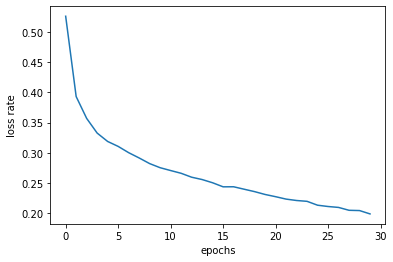

In [ ]:
# epochs 횟수 10 -> 30 변경
model = model_fn()
model.compile(loss='sparse_categorical_crossentropy', metrics='accuracy')
history = model.fit(train_scaled, train_target, epochs=30, verbose=0)
plt.plot(history.history['loss'])
plt.xlabel('epochs')
plt.ylabel('loss rate')
plt.show()


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


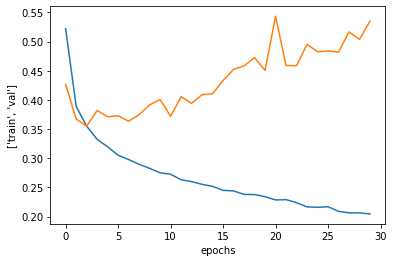

In [ ]:
# 검증 데이터 손실 값(RMSprop) 구하기 -> 과대적합
model = model_fn()
model.compile(loss='sparse_categorical_crossentropy', metrics='accuracy')
history = model.fit(train_scaled, train_target, epochs=30, verbose=0, validation_data=(val_scaled, val_target))
print(history.history.keys())

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epochs')
plt.ylabel(['train', 'val'])
plt.show()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


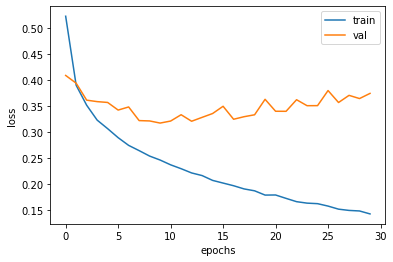

In [ ]:
# 검증 데이터 손실 값(adem) 구하기 -> 과대적합 감소
model = model_fn()
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics='accuracy')
history = model.fit(train_scaled, train_target, epochs=30, verbose=0, validation_data=(val_scaled, val_target))
print(history.history.keys())

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend(['train', 'val'])
plt.show()

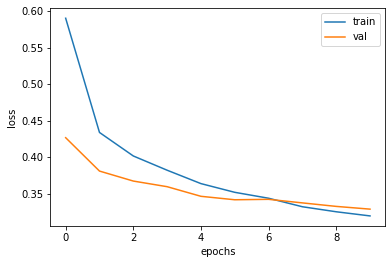

0.8821666666666667
375/375 [==============================] - 0s 973us/step - loss: 0.3258 - accuracy: 0.8822


[0.32581567764282227, 0.8821666836738586]

In [ ]:
# 3. 드롭아웃 -> 과대적합 최소화
model = model_fn(keras.layers.Dropout(0.3))

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics='accuracy')
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend(['train', 'val'])
plt.show()

# 모델 저장
model = model_fn(keras.layers.Dropout(0.3))
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics='accuracy')
history = model.fit(train_scaled, train_target, epochs=10, verbose=0, validation_data=(val_scaled, val_target))
model.save_weights('model_weights.h5')
model.save('model_whole.h5')

# 모델 비교하기
# 1. model_weights.h5
model = model_fn(keras.layers.Dropout(0.3))
model.load_weights('model_weights.h5')

import numpy as np
val_labels = np.argmax(model.predict(val_scaled), axis=1) # 가장 큰 예측값 반환
print(np.mean(val_labels == val_target))

# 2. model_whole.h5
model = keras.models.load_model('model_whole.h5')
model.evaluate(val_scaled, val_target)


375/375 [==============================] - 0s 925us/step - loss: 0.3202 - accuracy: 0.8834


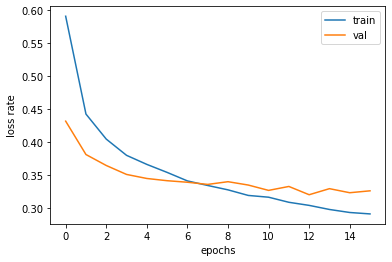

In [ ]:
# 4. 콜백(자동 모델 저장) -> 과대적합 에포크 찾기
model = model_fn(keras.layers.Dropout(0.3))
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics='accuracy')

checkpoint = keras.callbacks.ModelCheckpoint('best_model.h5', save_best_only=True)

# 조기종료
early_stop = keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)

history = model.fit(train_scaled, train_target, epochs=20, verbose=0, validation_data=(val_scaled,val_target), callbacks=[checkpoint, early_stop])

model.evaluate(val_scaled, val_target)

# 시각화
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epochs')
plt.ylabel('loss rate')
plt.legend(['train', 'val'])
plt.show()